In [1]:
model_name = "heads64_embed64_no_act"
dataset_name = "regress_gaussian"

In [2]:
import train

number of parameters: 0.000257 M 
step 0: train loss 0.4291, val loss 0.3970
step 10: train loss 0.4022, val loss 0.3737
step 20: train loss 0.3856, val loss 0.3756
step 30: train loss 0.3683, val loss 0.3694
step 40: train loss 0.3741, val loss 0.3644
step 50: train loss 0.3643, val loss 0.3752
step 60: train loss 0.3198, val loss 0.3255
step 70: train loss 0.3867, val loss 0.3564
step 80: train loss 0.3924, val loss 0.3715
step 90: train loss 0.4071, val loss 0.3786
step 100: train loss 0.3809, val loss 0.3833
step 110: train loss 0.3763, val loss 0.3880
step 120: train loss 0.3747, val loss 0.3915
step 130: train loss 0.3370, val loss 0.3143
step 140: train loss 0.3174, val loss 0.3342
step 150: train loss 0.2821, val loss 0.3056
step 160: train loss 0.3875, val loss 0.3487
step 170: train loss 0.3484, val loss 0.3280
step 180: train loss 0.3650, val loss 0.3471
step 190: train loss 0.3301, val loss 0.3226
step 200: train loss 0.2684, val loss 0.2564
step 210: train loss 0.4953, val

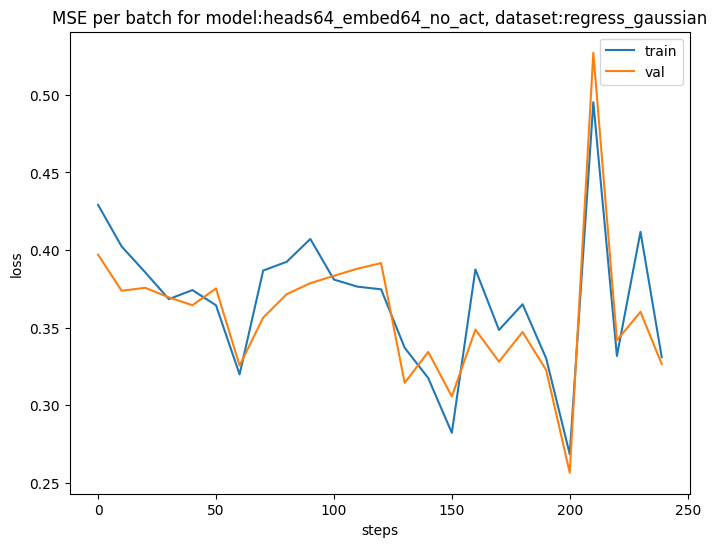

In [3]:
from draw import draw_loss
draw_loss(
    train.iter_list,
    train.train_losses, 
    train.val_losses, 
    f"MSE per batch for model:{model_name}, dataset:{dataset_name}", is_save=True
)

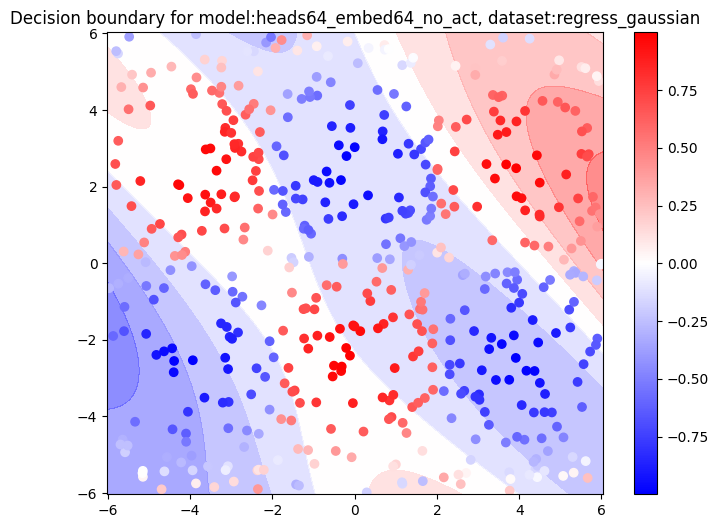

In [4]:
from draw import draw_dataset, draw_decision_boundary
# draw_dataset(train.valset, "Validation set")
draw_decision_boundary(
    train.model, 
    train.valset, 
    f"Decision boundary for model:{model_name}, dataset:{dataset_name}", 
    is_save=True
)